# Deep learning - Linear models 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, RNN

import warnings
warnings.filterwarnings('ignore')

2023-11-17 14:42:32.381773: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
plt.rcParams["figure.figsize"] = (9,6)

In [3]:
np.random.seed(42)
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)

In [4]:
train_df = pd.read_csv('data/train.csv')
val_df = pd.read_csv('data/val.csv')
test_df = pd.read_csv('data/test.csv')

In [5]:
train_df.head()

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT,day_sin,day_cos,year_sin,year_cos
0,0.588227,0.454943,0.599461,0.473673,0.556576,0.613765,0.691018,0.866025,5.000000e-01,0.010486,-0.999945
1,0.585130,0.459449,0.596738,0.471006,0.550279,0.620783,0.636233,0.965926,2.588190e-01,0.009770,-0.999952
2,0.572743,0.436920,0.591319,0.465748,0.512595,0.586144,0.636233,1.000000,7.440628e-12,0.009053,-0.999959
3,0.571194,0.450437,0.591319,0.468414,0.515693,0.599955,0.581468,0.965926,-2.588190e-01,0.008336,-0.999965
4,0.577388,0.450437,0.596738,0.473673,0.521990,0.599955,0.519656,0.866025,-5.000000e-01,0.007619,-0.999971


In [6]:
def format_timeseries_data(df, input_length, output_length, target_names):
    
    if target_names is not None:
        target_indices = {name: i for i, name in enumerate(target_names)}
    col_indices = {name: i for i, name in enumerate(df.columns)}
    
    total_length = input_length + output_length
    
    input_slice = slice(0, input_length)
    output_slice = slice(input_length, None)
    
    data = np.array(df, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=total_length,
        sequence_stride=1,
        shuffle=False,
        batch_size=32
    )
    
    def split_to_input_output(x):
            
        inputs = x[:, input_slice, :]
        outputs = x[:, output_slice, :]
        
        if target_names is not None:
            outputs = tf.stack(
                [outputs[:,:,col_indices[name]] for name in target_names],
                axis=-1
            )

        inputs.set_shape([None, input_length, None])
        outputs.set_shape([None, output_length, None])
    
        return inputs, outputs
    
    ds = ds.map(split_to_input_output)
    
    return ds

In [7]:
def train_model(model, train_ds, val_ds, patience=5, max_epochs=50):
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, mode='min')
    
    model.compile(loss=MeanSquaredError(), optimizer=Adam(), metrics=[MeanAbsoluteError()])
    
    history = model.fit(train_ds, epochs=max_epochs, validation_data=val_ds, callbacks=[early_stopping])
    
    return history

In [8]:
MULL_max_train = 7.568999767303468
MULL_min_train = -5.934000015258789
MULL_max_test = 4.690999984741211
MULL_min_test = -3.3399999141693115

OT_max_train = 46.00699996948242
OT_min_train = -4.079999923706056
OT_max_test = 17.165000915527347
OT_min_test = 3.025000095367432

## Single-step model 

In [9]:
train_ds_ss = format_timeseries_data(train_df, 1, 1, ['OT'])
val_ds_ss = format_timeseries_data(val_df, 1, 1, ['OT'])
test_ds_ss = format_timeseries_data(test_df, 1, 1, ['OT'])

ss_sample_batch = next(iter(test_ds_ss))

2023-11-17 14:42:38.537548: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
ss_linear = Sequential([
    Dense(units=1)
])

ss_linear_history = train_model(ss_linear, train_ds_ss, val_ds_ss)

Epoch 1/50
382/382 [==============================] - 2s 3ms/step - loss: 0.1654 - mean_absolute_error: 0.3268 - val_loss: 0.0671 - val_mean_absolute_error: 0.2249
Epoch 2/50
382/382 [==============================] - 1s 3ms/step - loss: 0.0419 - mean_absolute_error: 0.1686 - val_loss: 0.0297 - val_mean_absolute_error: 0.1544
Epoch 3/50
382/382 [==============================] - 1s 3ms/step - loss: 0.0187 - mean_absolute_error: 0.1104 - val_loss: 0.0132 - val_mean_absolute_error: 0.0984
Epoch 4/50
382/382 [==============================] - 1s 3ms/step - loss: 0.0128 - mean_absolute_error: 0.0890 - val_loss: 0.0051 - val_mean_absolute_error: 0.0576
Epoch 5/50
382/382 [==============================] - 1s 3ms/step - loss: 0.0104 - mean_absolute_error: 0.0780 - val_loss: 0.0041 - val_mean_absolute_error: 0.0496
Epoch 6/50
382/382 [==============================] - 1s 3ms/step - loss: 0.0087 - mean_absolute_error: 0.0696 - val_loss: 0.0047 - val_mean_absolute_error: 0.0526
Epoch 7/50
382/3

382/382 [==============================] - 1s 3ms/step - loss: 4.4389e-04 - mean_absolute_error: 0.0149 - val_loss: 1.6242e-04 - val_mean_absolute_error: 0.0094
Epoch 50/50
382/382 [==============================] - 1s 4ms/step - loss: 4.4282e-04 - mean_absolute_error: 0.0148 - val_loss: 1.6187e-04 - val_mean_absolute_error: 0.0094


In [11]:
def plot_history(history):

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)

    ax1.plot(history.history['loss'], label='Train')
    ax1.plot(history.history['val_loss'], label='Validation')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss')
    ax1.legend(loc='best')

    ax2.plot(history.history['mean_absolute_error'], label='Train')
    ax2.plot(history.history['val_mean_absolute_error'], label='Validation')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('MAE')
    ax2.set_title('Mean absolute error')
    ax2.legend(loc='best')

    plt.tight_layout()

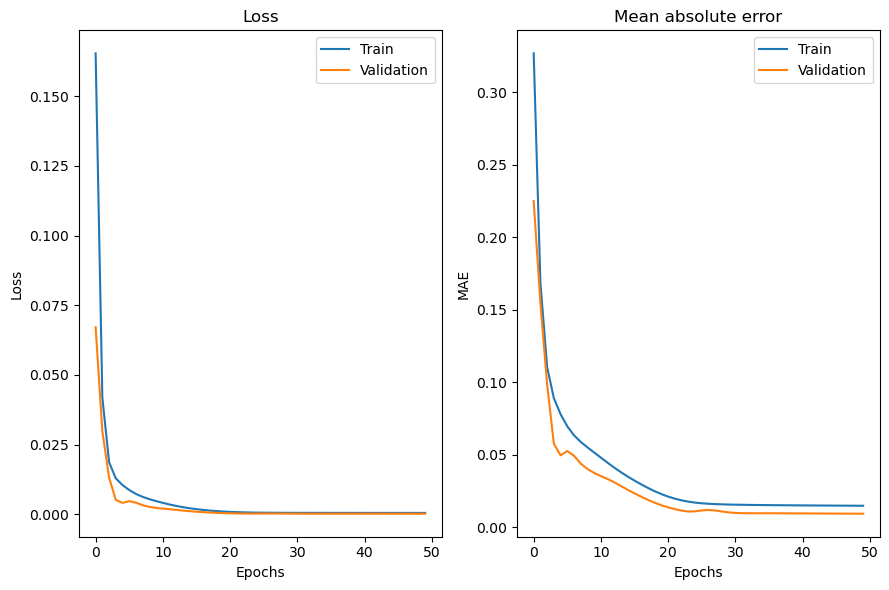

In [12]:
plot_history(ss_linear_history)

In [13]:
def plot_predictions(model, sample_batch, model_type):
    
    inputs, outputs = sample_batch
    preds = model(inputs)
    
    if model_type == 'single_step':      

        fig, ax = plt.subplots()

        actual_scaled = outputs.numpy().flatten()
        actual = actual_scaled * (OT_max_test - OT_min_test) + OT_min_test
        
        predictions_scaled = preds.numpy().flatten()
        predictions = predictions_scaled * (OT_max_train - OT_min_train) + OT_min_train
        
        ax.plot(actual, label='Actual')
        ax.plot(predictions, label='Predicted')
        ax.set_xlabel('Time steps')
        ax.set_ylabel('Oil temperature')
        ax.set_title('Predictions on a sample batch')
        ax.legend(loc='best')
        
    elif model_type == 'multi_step':

        fig, ax = plt.subplots()
        
        actual_scaled = outputs.numpy().flatten()[:48]
        actual = actual_scaled * (OT_max_test - OT_min_test) + OT_min_test
        
        predictions_scaled = preds.numpy().flatten()[:48]
        predictions = predictions_scaled * (OT_max_train - OT_min_train) + OT_min_train

        ax.plot(actual, label='Actual')
        ax.plot(predictions, label='Predicted')
        ax.set_xlabel('Time steps')
        ax.set_ylabel('Oil temperature')
        ax.set_title('Predictions on a sample batch')
        ax.legend(loc='best')
        
    elif model_type == 'multi_output':
        
        fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
        
        OT_actual_scaled = outputs.numpy().flatten()[0::2]
        OT_actual = OT_actual_scaled * (OT_max_test - OT_min_test) + OT_min_test
        
        OT_predictions_scaled = preds.numpy().flatten()[0::2]
        OT_predictions = OT_predictions_scaled * (OT_max_train - OT_min_train) + OT_min_train

        MULL_actual_scaled = outputs.numpy().flatten()[1::2]
        MULL_actual = MULL_actual_scaled * (MULL_max_test - MULL_min_test) + MULL_min_test
        
        MULL_predictions_scaled = preds.numpy().flatten()[1::2]
        MULL_predictions = MULL_predictions_scaled * (MULL_max_train - MULL_min_train) + MULL_min_train
        
        ax1.plot(OT_actual, label='Actual')
        ax1.plot(OT_predictions, label='Predicted')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Oil temperature')
        ax1.legend(loc='best')
        ax1.set_title('Predictions on a sample batch')
        
        ax2.plot(MULL_actual, label='Actual')
        ax2.plot(MULL_predictions, label='Predicted')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('MULL')
        ax2.legend(loc='best')
        
    plt.tight_layout()

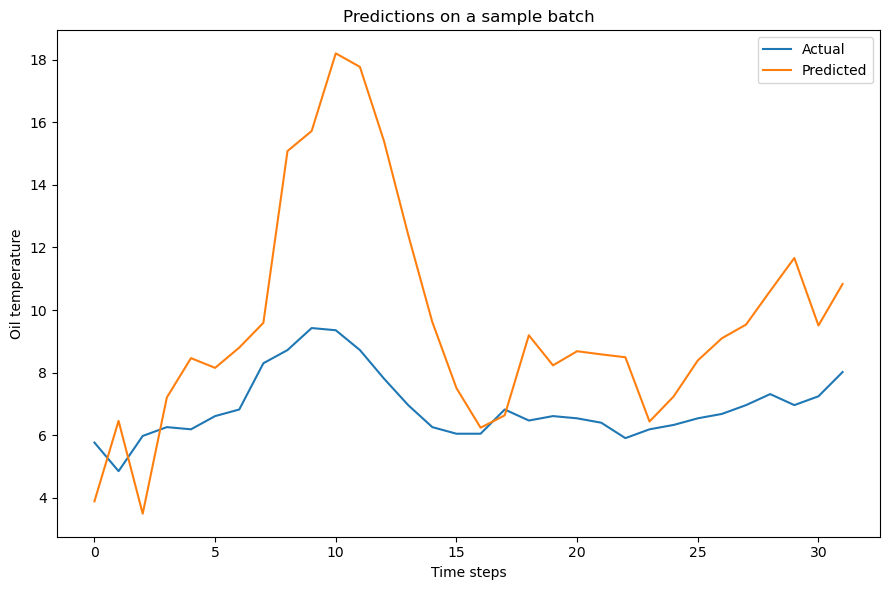

In [14]:
plot_predictions(ss_linear, ss_sample_batch, 'single_step')

## Multi-step model 

In [15]:
train_ds_ms = format_timeseries_data(train_df, 24, 24, ['OT'])
val_ds_ms = format_timeseries_data(val_df, 24, 24, ['OT'])
test_ds_ms = format_timeseries_data(test_df, 24, 24, ['OT'])

ms_sample_batch = next(iter(test_ds_ms))

In [16]:
ms_linear = Sequential([
    Dense(units=1)
])

ms_linear_history = train_model(ms_linear, train_ds_ms, val_ds_ms)

Epoch 1/50
380/380 [==============================] - 2s 3ms/step - loss: 0.2100 - mean_absolute_error: 0.3621 - val_loss: 0.0767 - val_mean_absolute_error: 0.2417
Epoch 2/50
380/380 [==============================] - 1s 4ms/step - loss: 0.0488 - mean_absolute_error: 0.1815 - val_loss: 0.0281 - val_mean_absolute_error: 0.1357
Epoch 3/50
380/380 [==============================] - 1s 3ms/step - loss: 0.0263 - mean_absolute_error: 0.1277 - val_loss: 0.0245 - val_mean_absolute_error: 0.1241
Epoch 4/50
380/380 [==============================] - 1s 3ms/step - loss: 0.0205 - mean_absolute_error: 0.1114 - val_loss: 0.0286 - val_mean_absolute_error: 0.1375
Epoch 5/50
380/380 [==============================] - 1s 4ms/step - loss: 0.0171 - mean_absolute_error: 0.1023 - val_loss: 0.0291 - val_mean_absolute_error: 0.1407
Epoch 6/50
380/380 [==============================] - 1s 4ms/step - loss: 0.0144 - mean_absolute_error: 0.0944 - val_loss: 0.0255 - val_mean_absolute_error: 0.1319
Epoch 7/50
380/3

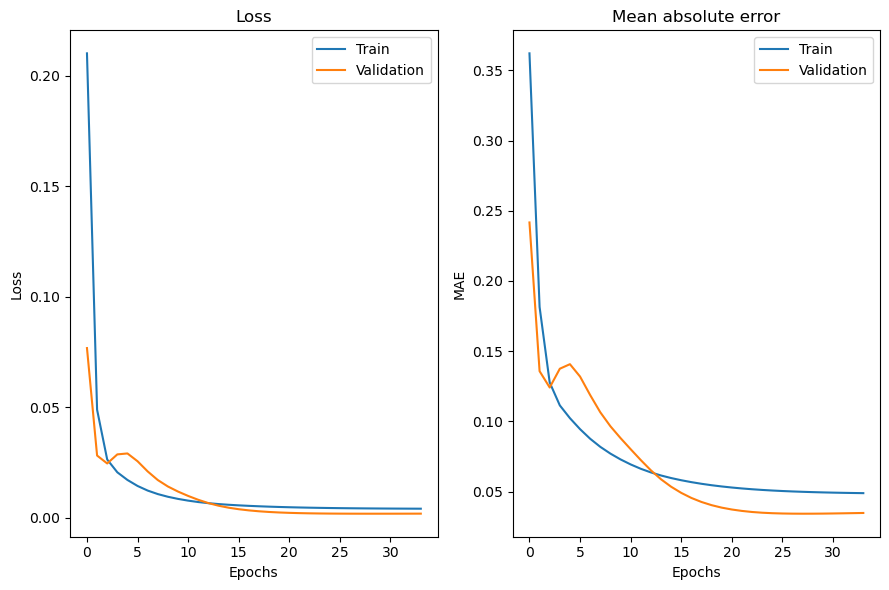

In [17]:
plot_history(ms_linear_history)

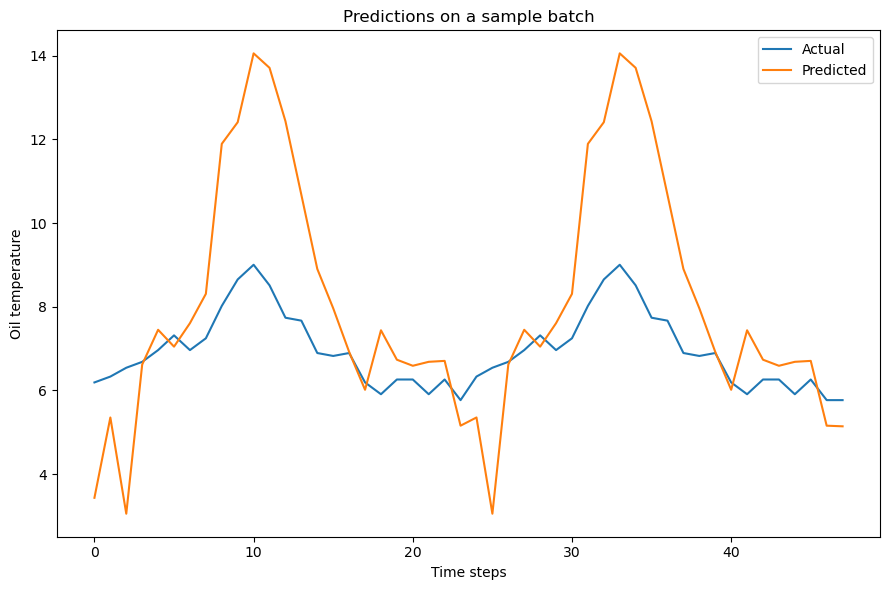

In [18]:
plot_predictions(ms_linear, ms_sample_batch, 'multi_step')

## Multi_output 

In [19]:
train_ds_mo = format_timeseries_data(train_df, 1, 1, ['OT', 'MULL'])
val_ds_mo = format_timeseries_data(val_df, 1, 1, ['OT', 'MULL'])
test_ds_mo = format_timeseries_data(test_df, 1, 1, ['OT', 'MULL'])

mo_sample_batch = next(iter(test_ds_mo))

In [20]:
mo_linear = Sequential([
    Dense(units=2)
])

mo_linear_history = train_model(mo_linear, train_ds_mo, val_ds_mo)

Epoch 1/50
382/382 [==============================] - 2s 3ms/step - loss: 0.2673 - mean_absolute_error: 0.4178 - val_loss: 0.0487 - val_mean_absolute_error: 0.1801
Epoch 2/50
382/382 [==============================] - 1s 3ms/step - loss: 0.0541 - mean_absolute_error: 0.1802 - val_loss: 0.0206 - val_mean_absolute_error: 0.1121
Epoch 3/50
382/382 [==============================] - 1s 3ms/step - loss: 0.0334 - mean_absolute_error: 0.1403 - val_loss: 0.0152 - val_mean_absolute_error: 0.0962
Epoch 4/50
382/382 [==============================] - 1s 3ms/step - loss: 0.0259 - mean_absolute_error: 0.1244 - val_loss: 0.0172 - val_mean_absolute_error: 0.1038
Epoch 5/50
382/382 [==============================] - 1s 3ms/step - loss: 0.0216 - mean_absolute_error: 0.1133 - val_loss: 0.0200 - val_mean_absolute_error: 0.1137
Epoch 6/50
382/382 [==============================] - 1s 3ms/step - loss: 0.0185 - mean_absolute_error: 0.1043 - val_loss: 0.0199 - val_mean_absolute_error: 0.1143
Epoch 7/50
382/3

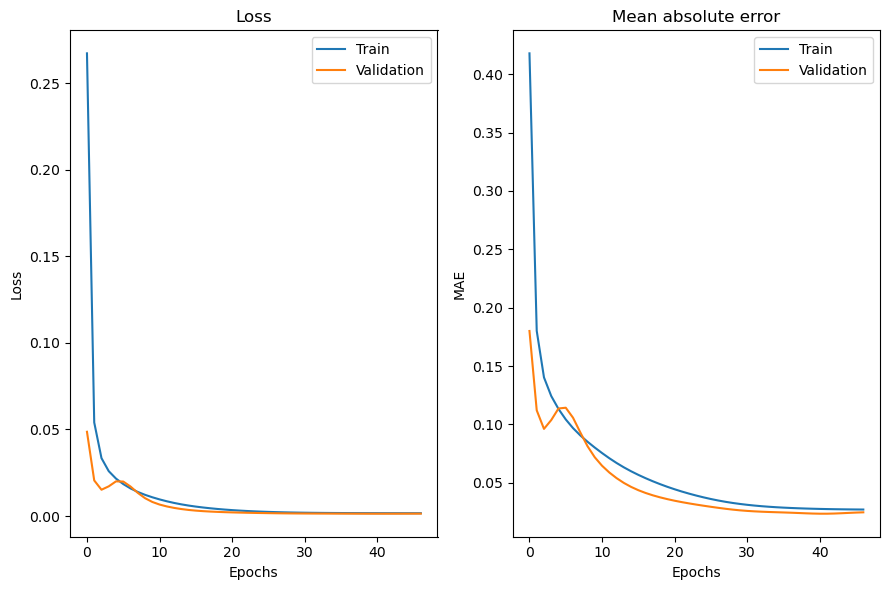

In [21]:
plot_history(mo_linear_history)

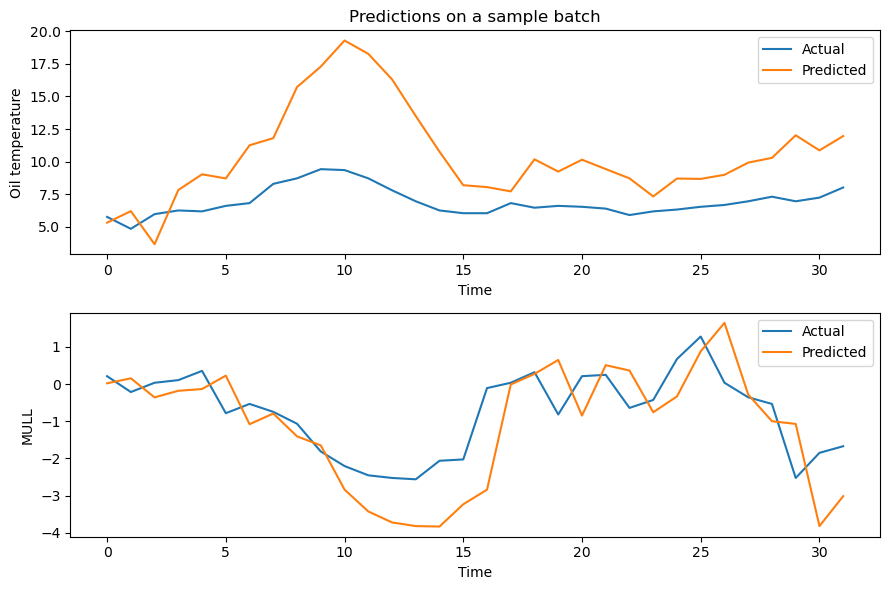

In [22]:
plot_predictions(mo_linear, mo_sample_batch, 'multi_output')

## Evaluation 

In [23]:
mae_linear_ss = ss_linear.evaluate(test_ds_ss)[1]
mae_linear_ms = ms_linear.evaluate(test_ds_ms)[1]
mae_linear_mo = mo_linear.evaluate(test_ds_mo)[1]

55/55 [==============================] - 0s 3ms/step - loss: 0.0049 - mean_absolute_error: 0.0495
